### Homework 3 | Generative Adversarial Networks| 15 Points Total

In this homework you will be taking a look the architecture, loss functions, data generation, and training of a few different types of models. First you will build a generic GAN to generate new unconditional samples from MNIST. Then you will build [Pix2Pix](https://phillipi.github.io/pix2pix/) model that we looked at in class previously using an existing dataset. Finally, you will need to generate or collect your own dataset and train a pix2pix model that does conditional image generation.

In [1]:
#Let's start by importing the necessary libraries for this assignment
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import torchinfo
import urllib.request
import os
from PIL import Image

In [2]:
#Let's also check if a GPU is available and set the device accordingly for mac/windows users
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


#### Part 1 | Unconditional GAN

In this section you will define a simple GAN model for unconditional image generation. After training, our expectation is that we should be able to feed in random noise and get back a sample that is convincingly from the distribution of the training dataset.

A GAN is made up of two competing models. These models are generally referred to as the **Generator** and the **Discriminator**. The specific model setup is not defined in [Goodfellow et al.](https://arxiv.org/abs/1406.2661), but we can infer many of the details from the paper and build two MLP style models with a reasonably large capacity. *Reasonably large* is a pretty arbitrary specification. Feel free to experiment with the input/output sizes of the layers in the generator and discriminator to see how it affects the results of your model. 

 Let's start by defining the `Generator` with it's `init` and `forward` methods. This model should just take in a noise vector of `z_dim` and upsample this until it outputs an image the same shape as the MNIST images (28x28).

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        #Store the dimension of the noise vector
        self.z_dim = z_dim

        #Define the layers of the generator
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),  # MNIST images are 28x28
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28) # Reshape output to image shape (batch_size, channels, x_dim, y_dim)

Now we will define the `Discriminator` which should take in either a real image from the training set or a synthetic image from the `Generator` and make a binary prediction of whether it is a real or fake image. 

Goodfellow et. al. suggests the use of dropout layers to promote training stability. They also recommend the use of [maxout activations](https://paperswithcode.com/method/maxout), however we will use [Leaky ReLU](https://paperswithcode.com/method/leaky-relu) instead. 

[Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) looks like the standard ReLU, but has a slight slope for values below 0 to prevent [*vanishing gradients*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).





In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2), # Leaky ReLU activation function with a slope of 0.2
            nn.Dropout(0.3),  # Dropout layer
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2), # Leaky ReLU activation function with a slope of 0.2
            nn.Dropout(0.3),  # Dropout layer
            nn.Linear(256, 1),  # Output a single value
            nn.Sigmoid()  # Output prediction values between 0 and 1
        )

    def forward(self, img):
        return self.model(img)

Great! Now we have our two models defined. Next we will define the loss function and optimizer for our GAN. Recall that the process for training the GAN model is as follows:

1. Initialize the generator and discriminator models
2. Set the number of training epochs
3. Define the loss function (e.g., Binary Cross-Entropy)
4. Choose optimizers for both the generator and discriminator (e.g., Adam)

5. For each epoch:

    For each batch of real images from the training dataset:
    
        i. Generate random noise (z) as input for the generator
        
        ii. Use the generator to create fake images (G(z))
        
        iii. Compute the discriminator's predictions:
            - Real images: D(real_images)
            - Fake images: D(G(z))
        
        iv. Calculate the loss for the discriminator:
            - Loss_D = - (mean(log(D(real_images))) + mean(log(1 - D(G(z)))))
        
        v. Update the discriminator's weights using the calculated loss
        
        vi. Generate new random noise (z) for the generator
        vii. Compute the discriminator's predictions for the fake images again: D(G(z))
        
        viii. Calculate the loss for the generator:
            - Loss_G = - mean(log(D(G(z))))
        
        ix. Update the generator's weights using the calculated loss

6. End training after the specified number of epochs

First you should initialize your generator and discriminator and set up your optimizers for the generator and discriminator. (1 point)

In [6]:
z_dim = 100

generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

n_epochs = 100
batch_size = 64
lr = 0.0002

loss_fn = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

Before we go much further it it would be nice if we have a function that we can call to plot some random samples with our generator. This will let us check the progress of the optimization as it progresses. 

This function will be called `generate_images(generator, num_images, noise_dim, device)` and it should not have a return value, it should just plot a set of images.

In [ ]:
def generate_images(generator, num_images, noise_dim, device):
    #First you need to create a set of random z vectors that have the shape (num_images, noise_dim)
    #Hint: use torch.randn()
    ###Your code here

    #Next we will stop tracking gradients for a bit to generate the images
    #Hint: look up .cpu()
    with torch.no_grad():
        generated_images = ###Your code here

    #Now that you have your generated images you can plot them in a subplot
    #Hint: use plt.subplots()
    """
    Your Code here
    """

Now we have everything we need to define our training loop. Let's also set this up as a function we can call later on.

In [8]:
def generate_images(generator, num_images, noise_dim, device):
    z = torch.randn(num_images, noise_dim).to(device)
    with torch.no_grad():
        generated_imgs = generator(z).cpu()

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))
    for i in range(num_images):
        axes[i].imshow(generated_imgs[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

def train_gan(generator, discriminator, n_epochs, batch_size, lr, loss_fn, optimizer_G, optimizer_D, dataloader, device):
    z_dim = generator.z_dim

    for epoch in tqdm(range(n_epochs)):
        for i, (real_images, _) in enumerate(dataloader):
            # Move real images to device
            real_images = real_images.to(device)

            #Create labels for real and fake images
            real_labels = torch.ones(real_images.shape[0]).unsqueeze(-1).to(device)
            fake_labels = torch.zeros(real_images.shape[0]).unsqueeze(-1).to(device)

            #Zero out the gradients for the discriminator optimizer
            optimizer_D.zero_grad()

            #Have the discriminator make predictions on the real and fake images
            real_preds = discriminator(real_images)

            #Calculate the discriminator loss w.r.t. the real images
            loss_D_real = loss_fn(real_preds, real_labels)

            #Generate random noise for the generator
            z = torch.randn(real_images.shape[0], z_dim).to(device) 
            fake_images = generator(z)

            #Have the discriminator make predictions on the fake images
            fake_preds = discriminator(fake_images.detach())

            #Calculate the discriminator loss w.r.t. the fake images
            loss_D_fake = loss_fn(fake_preds, fake_labels)

            #Calculate the total discriminator loss
            loss_D = loss_D_real + loss_D_fake

            #Backpropagate the discriminator loss
            loss_D.backward()

            #Update the discriminator weights
            optimizer_D.step()

            #Zero out the gradients for the generator optimizer
            optimizer_G.zero_grad()

            #Have the discriminator make predictions on the fake images again
            fake_preds = discriminator(fake_images)

            #Calculate the generator loss
            loss_G = loss_fn(fake_preds, real_labels)

            #Backpropagate the generator loss
            loss_G.backward()

            #Update the generator weights
            optimizer_G.step()

            #Print the losses for each batch
            if i % 100 == 0:
                clear_output(wait=True)
                print(f"Epoch [{epoch+1}/{n_epochs}] | Batch [{i+1}/{len(dataloader)}] | Loss_D: {loss_D:.4f} | Loss_G: {loss_G:.4f}")
                generate_images(generator, 10, z_dim, device)


Now that we have our model defined, we need some data to train our model. Let's use the MNIST dataset and create a dataloader that transforms the images to a tensor and normalizes them to -1 to 1 to match the expected range of outputs from the generator.

In [9]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Epoch [8/100] | Batch [501/938] | Loss_D: 0.7169 | Loss_G: 3.8776


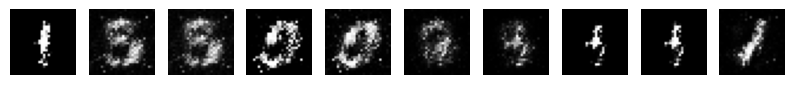

  7%|▋         | 7/100 [01:32<20:32, 13.25s/it]


KeyboardInterrupt: 

In [10]:
train_gan(generator, discriminator, n_epochs, batch_size, lr, loss_fn, optimizer_G, optimizer_D, dataloader, device)

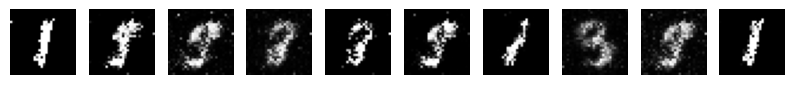

In [11]:
generate_images(generator, 10, z_dim, device)


Now let's see what happens if we try to interpolate between random latent vectors! (3 points)

For this section you will need to first generate two random vectors `z1` and `z2`
>Hint: use torch.randn()

Then you need to create a set of interpolated latent vectors between `z1` and `z2`. You should create 10 steps between the latent codes to sample.
>Hint: use [torch.linspace()](https://pytorch.org/docs/stable/generated/torch.linspace.html) and [torch.lerp()](https://pytorch.org/docs/stable/generated/torch.lerp.html) to generate these latent vectors.

Then you need to use your trained generator to create new images given each of these latent vectors.

In [12]:
#First you need to generate two random vectors with the shape (1, z_dim)
z1 = torch.randn(1, z_dim).to(device)
z2 = torch.randn(1, z_dim).to(device)


steps = 10
interpolation_range = torch.linspace(0, 1, steps=steps).unsqueeze(1).to(device)
print(interpolation_range.shape)
interpolated_z = torch.lerp(z1, z2, interpolation_range).squeeze(0).to(device)

#Now let's generate images for the interpolated latent vectors
interpolated_images = generator(interpolated_z)
print(interpolated_images.shape)


torch.Size([10, 1])
torch.Size([10, 1, 28, 28])


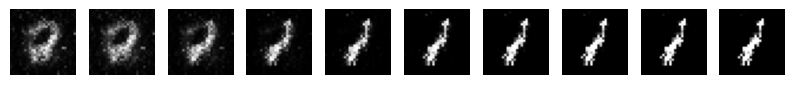

In [13]:
#Now let's plot the interpolated images
fig, axes = plt.subplots(1, steps, figsize=(10, 10))
for i in range(steps):
    axes[i].imshow(interpolated_images[i].squeeze().detach().cpu(), cmap='gray')
    axes[i].axis('off')
plt.show()


#### Part 2 | Conditional GAN | pix2pix

In this section you will be building a **cGAN** based on the paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004) by Isola et. al. The code here is adapted from [Philip Isola's github repo](https://github.com/phillipi/pix2pix). 

The general setup for this model will look very similar to the unconditional GAN model above. You will again have a `Generator` and a `Discriminator` model, however this time you will need to feed the input image into the discriminator model as your condition.

![pix2pix](imgs/pix2pix.png)

The `Generator` used is a `U-Net` architecture. A `U-Net` model architeecture is described in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) and follows a symmetrical convolutional encoder-decoder architecture. It also includes skip connections to allow information to 'shortcut' across the network. 



The `Discriminator` uses a convolutional `PatchGAN` classifier. The `PatchGAN` is claimed by the authors to work on a wider range of problems since it only penalizes structure at the scale of image patches. Here an image patch is just meant to be some smaller subsection of an image. The best results from the paper were achieved using a PatchGAN with 'receptive-fields' that were 70 pixels x 70 pixels. 

![patch_gan.png](imgs/patch_gan.png)

In the paper they describe the network architecture using a compact notation:

>Let Ck denote a Convolution-BatchNorm-ReLU layer  with k filters. CDk denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All convolutions are 4 × 4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample  by a factor of 2, whereas in the decoder they upsample by a  factor of 2.

>The encoder-decoder architecture consists of:  encoder:  `C64-C128-C256-C512-C512-C512-C512-C512`  decoder:  `CD512-CD512-CD512-C512-C256-C128-C64`  After the last layer in the decoder, a convolution is applied to map to the number of output channels (3 in general,  except in colorization, where it is 2), followed by a Tanh  function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.  All ReLUs in the encoder are leaky, with slope 0.2, while  ReLUs in the decoder are not leaky.  The U-Net architecture is identical except with skip connections between each layer i in the encoder and layer n − i  in the decoder, where n is the total number of layers. The  skip connections concatenate activations from layer i to  layer n − i. This changes the number of channels in the  decoder:  U-Net decoder:  `CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128`

>The 70 × 70 discriminator architecture is:  `C64-C128-C256-C512`  After the last layer, a convolution is applied to map to  a 1-dimensional output, followed by a Sigmoid function.  As an exception to the above notation, BatchNorm is not  applied to the first C64 layer. All ReLUs are leaky, with  slope 0.2.

In these modules I have written out all of the steps in sequence to make it easier to follow the flow of data through the model. In practice you should write some functions that generate these models automatically using some other kind of logic (i.e. for loops and nn.Sequential()). The code from github does this model generation in a way that handles a variety of scenarios, however it is not the most straightforward code to read. The architecture defined below is designed for input images that are 256x256. If you try to run smaller images through the network you will get an error. 

In [14]:

class GeneratorUNet(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(GeneratorUNet, self).__init__()
        self.e1 = nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1)

        self.e2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.be2 = nn.InstanceNorm2d(128)

        self.e3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.be3 = nn.InstanceNorm2d(256)

        self.e4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.be4 = nn.InstanceNorm2d(512)

        self.e5 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.be5 = nn.InstanceNorm2d(512)

        self.e6 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.be6 = nn.InstanceNorm2d(512)

        self.e7 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.be7 = nn.InstanceNorm2d(512)

        self.e8 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.be8 = nn.InstanceNorm2d(512)

        self.d1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.bd1 = nn.InstanceNorm2d(512)

        self.d2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bd2 = nn.InstanceNorm2d(512)

        self.d3 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bd3 = nn.InstanceNorm2d(512)

        self.d4 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bd4 = nn.InstanceNorm2d(512)

        self.d5 = nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1)
        self.bd5 = nn.InstanceNorm2d(256)

        self.d6 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)
        self.bd6 = nn.InstanceNorm2d(128)

        self.d7 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.bd7 = nn.InstanceNorm2d(64)

        self.d8 = nn.ConvTranspose2d(128, output_nc, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x1 = F.leaky_relu(self.e1(x), 0.2)  # Apply first convolution and Leaky ReLU activation
        x2 = F.leaky_relu(self.be2(self.e2(x1)), 0.2)  # Apply second convolution, instance normalization, and Leaky ReLU
        x3 = F.leaky_relu(self.be3(self.e3(x2)), 0.2)  # Apply third convolution, instance normalization, and Leaky ReLU
        x4 = F.leaky_relu(self.be4(self.e4(x3)), 0.2)  # Apply fourth convolution, instance normalization, and Leaky ReLU
        x5 = F.leaky_relu(self.be5(self.e5(x4)), 0.2)  # Apply fifth convolution, instance normalization, and Leaky ReLU
        x6 = F.leaky_relu(self.be6(self.e6(x5)), 0.2)  # Apply sixth convolution, instance normalization, and Leaky ReLU
        x7 = F.leaky_relu(self.be7(self.e7(x6)), 0.2)  # Apply seventh convolution, instance normalization, and Leaky ReLU
        x8 = F.leaky_relu(self.e8(x7), 0.2)  # Apply eighth convolution and Leaky ReLU

        x = F.relu(self.bd1(self.d1(x8)))  # Upsample with first transposed convolution and apply ReLU
        x = F.dropout2d(x, 0.5)  # Apply dropout for regularization
        x = F.relu(self.bd2(self.d2(torch.cat([x, x7], 1))))  # Concatenate with skip connection and apply second upsample
        x = F.dropout2d(x, 0.5)  # Apply dropout for regularization
        x = F.relu(self.bd3(self.d3(torch.cat([x, x6], 1))))  # Concatenate with skip connection and apply third upsample
        x = F.relu(self.bd4(self.d4(torch.cat([x, x5], 1))))  # Concatenate with skip connection and apply fourth upsample
        x = F.relu(self.bd5(self.d5(torch.cat([x, x4], 1))))  # Concatenate with skip connection and apply fifth upsample
        x = F.relu(self.bd6(self.d6(torch.cat([x, x3], 1))))  # Concatenate with skip connection and apply sixth upsample
        x = F.relu(self.bd7(self.d7(torch.cat([x, x2], 1))))  # Concatenate with skip connection and apply seventh upsample
        x = F.tanh(self.d8(torch.cat([x, x1], 1)))  # Concatenate with skip connection and apply final transposed convolution with Tanh activation
        return x
    
class DiscriminatorPatchGAN(nn.Module):
    def __init__(self, input_nc, condition_nc):
        super(DiscriminatorPatchGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc + condition_nc, 64, kernel_size=4, stride=2, padding=1),  # Combine input and condition
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output a single value
        )

    def forward(self, img, condition):
        # Concatenate the input image and condition along the channel dimension
        x = torch.cat([img, condition], 1)
        return self.model(x)

Again, we will initialize our generator and discriminator models. 

In [15]:
generator_unet = GeneratorUNet(input_nc=3, output_nc=3).to(device)
discriminator_patchgan = DiscriminatorPatchGAN(input_nc=3, condition_nc=3).to(device)

In [16]:
torchinfo.summary(generator_unet, (1, 3, 256, 256), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GeneratorUNet                            [1, 3, 256, 256]          --
├─Conv2d: 1-1                            [1, 64, 128, 128]         3,136
├─Conv2d: 1-2                            [1, 128, 64, 64]          131,200
├─InstanceNorm2d: 1-3                    [1, 128, 64, 64]          --
├─Conv2d: 1-4                            [1, 256, 32, 32]          524,544
├─InstanceNorm2d: 1-5                    [1, 256, 32, 32]          --
├─Conv2d: 1-6                            [1, 512, 16, 16]          2,097,664
├─InstanceNorm2d: 1-7                    [1, 512, 16, 16]          --
├─Conv2d: 1-8                            [1, 512, 8, 8]            4,194,816
├─InstanceNorm2d: 1-9                    [1, 512, 8, 8]            --
├─Conv2d: 1-10                           [1, 512, 4, 4]            4,194,816
├─InstanceNorm2d: 1-11                   [1, 512, 4, 4]            --
├─Conv2d: 1-12                           [1, 512, 2

In [17]:
torchinfo.summary(discriminator_patchgan,((1, 3, 256, 256), (1,3, 256, 256)), device=device)


Layer (type:depth-idx)                   Output Shape              Param #
DiscriminatorPatchGAN                    [1, 1, 15, 15]            --
├─Sequential: 1-1                        [1, 1, 15, 15]            --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         6,208
│    └─LeakyReLU: 2-2                    [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 128, 64, 64]          131,200
│    └─InstanceNorm2d: 2-4               [1, 128, 64, 64]          --
│    └─LeakyReLU: 2-5                    [1, 128, 64, 64]          --
│    └─Conv2d: 2-6                       [1, 256, 32, 32]          524,544
│    └─InstanceNorm2d: 2-7               [1, 256, 32, 32]          --
│    └─LeakyReLU: 2-8                    [1, 256, 32, 32]          --
│    └─Conv2d: 2-9                       [1, 512, 16, 16]          2,097,664
│    └─InstanceNorm2d: 2-10              [1, 512, 16, 16]          --
│    └─LeakyReLU: 2-11                   [1, 512, 16, 16]        

Now we need to initialize the weights of the networks to match the paper. We will just use the init_weights function they defined. 

In [18]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

init_weights(generator_unet, init_type='normal', init_gain=0.02)
init_weights(discriminator_patchgan, init_type='normal', init_gain=0.02)



initialize network with normal
initialize network with normal


In [19]:
lr = 0.0002
beta1 = 0.5 #momentum
beta2 = 0.999 #alpha

g_optimizer = optim.Adam(generator_unet.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator_patchgan.parameters(), lr=lr, betas=(beta1, beta2))

Now let's download some data and create the dataloader. You will be using the facades dataset for this homework since it is nice and small.

In [20]:

def download_facades(url, save_path):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    if not os.path.exists(save_path):
        print(f"Downloading dataset from {url}...")
        urllib.request.urlretrieve(url, save_path)
        print("Download complete.")
    else:
        print("Dataset already downloaded.")

# URL for the edges2shoes dataset
facades_url = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'
save_path = './datasets/facades.tar.gz'

download_facades(facades_url, save_path)

Dataset already downloaded.


In [21]:
# Extract the dataset
import tarfile

def extract_dataset(tar_path, extract_path):
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)

if not os.path.exists('./datasets/facades'):
    extract_dataset(save_path, './datasets')
else:
    print("Dataset already extracted.") 

Dataset already extracted.


In [22]:
class FacadesDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []

        for root, dirs, files in os.walk(root):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    self.images.append(os.path.join(root, file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image

In [23]:
transform = transforms.Compose([    
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),(0.5,0.5,0.5))
])

facades_dataset = FacadesDataset(root='./datasets/facades/', transform=transform)
facades_dataloader = DataLoader(facades_dataset, batch_size=1, shuffle=True)


Let's print a sample from our facades dataset.

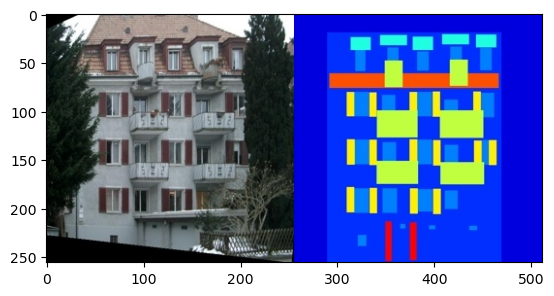

In [24]:
sample = next(iter(facades_dataloader))
plt.imshow((sample[0].permute(1, 2, 0) + 1.0) / 2.0)
plt.show()



Here we see that the dataset is set up with pairs of images composed together into one frame. This means that we just need to choose half of our image to be fed into the generator and the other half will serve as the ground truth. You can train a model to go from segmentation labels to photos or photos to segmentation labels.

In [25]:
def GAN_loss(output, target):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(output, target)
    return loss

def l1_loss(output, target):
    criterion = nn.L1Loss()
    loss = criterion(output, target)
    return loss

def plot_sample_grid(condition, fake_photo, real_photo):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(condition)
    axs[0].set_title('Condition')
    axs[1].imshow(fake_photo)
    axs[1].set_title('Fake Photo')
    axs[2].imshow(real_photo)
    axs[2].set_title('Real Photo')
    plt.show()

def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

#From https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/util/util.py
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)



In this model you will be trying to go from facade labels to photos of facades. The goal of the generator is to create realistic looking images of facades, given a labeled facade image. The goal of the discriminator is to determine if the generated image is a real photo of a facade or a generated photo of a facade.

In [26]:
def train_pix2pix(generator, discriminator, dataloader, device, lambda_l1=100, num_epochs=25):
    for epoch in tqdm(range(num_epochs)):
        for i, data in enumerate(dataloader):
            #Take half of the image as the input and the other half as the ground truth
            real_photo = data[..., :256].to(device)
            condition = data[..., 256:].to(device) 

            # Start Generation Here
            # Train Discriminator
            set_requires_grad(discriminator, True)
            d_optimizer.zero_grad()

            # Fake pairs
            fake_photo = generator(condition)
            pred_fake = discriminator(fake_photo.detach(), condition)
            fake = torch.zeros_like(pred_fake, device=device)
            loss_D_fake = GAN_loss(pred_fake, fake)

            # Real pairs
            pred_real = discriminator(real_photo, condition) #The discriminator takes in the real/fake photo and the condition
            valid = torch.ones_like(pred_real, device=device)
            loss_D_real = GAN_loss(pred_real, valid)    

            # Total Discriminator loss
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            d_optimizer.step()
            
            # Train Generator
            set_requires_grad(discriminator, False)
            g_optimizer.zero_grad()
            pred_fake = discriminator(fake_photo, condition)
            loss_G_GAN = GAN_loss(pred_fake, valid)
            loss_G_L1 = l1_loss(fake_photo, real_photo) * lambda_l1
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            g_optimizer.step()

            
            # Start Generation Here        
            if i % 50 ==0:
                clear_output(wait=True)
                print(f"Epoch {epoch+1}/{num_epochs}, Loss_D: {loss_D.item()}, Loss_G_GAN: {loss_G_GAN.item()}, Loss_G_L1: {loss_G_L1.item()}")
                with torch.no_grad():            
                    fake_image = generator(condition)[0]
                    fake_photo_img = tensor2im(fake_image)
                    real_photo_img = tensor2im(real_photo[0])
                    plot_sample_grid(tensor2im(condition.squeeze(0)), fake_photo_img, real_photo_img)

    


Epoch 25/25, Loss_D: 0.1368888020515442, Loss_G_GAN: 3.039433240890503, Loss_G_L1: 16.51357078552246


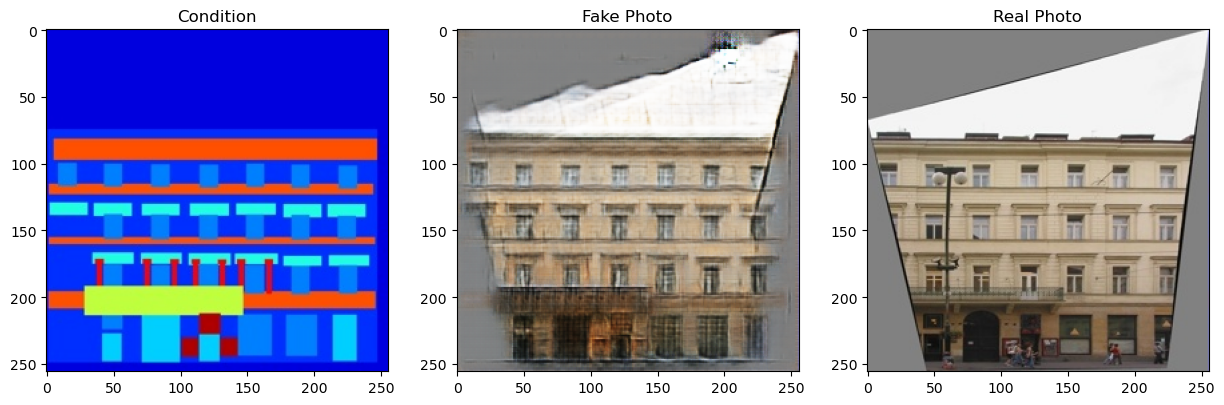

100%|██████████| 25/25 [12:42<00:00, 30.50s/it]


In [27]:
train_pix2pix(generator_unet, discriminator_patchgan, facades_dataloader, device)


Great! With any luck (and a bit of training time) you should begin to see improvements in the generation of fake photos given a labeled condition image as input. 